# Baseline Models for Sentiment Analysis

## Overview
This notebook implements baseline machine learning models for Twitter sentiment classification using traditional feature extraction methods.

## Models
1. **Naive Bayes** (MultinomialNB)
2. **Logistic Regression**

## Feature Extraction Methods
1. **Count Vectorizer** (Word Frequency / Bag of Words)
2. **TF-IDF Vectorizer** (Term Frequency - Inverse Document Frequency)

## Evaluation Metrics
- Accuracy
- Precision, Recall, F1-Score
- Confusion Matrix
- Classification Report

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Text preprocessing
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

print("✓ Libraries imported successfully!")

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


✓ Libraries imported successfully!


[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


## 2. Load and Prepare Data

In [2]:
# Try to load cleaned data first, otherwise load raw data
import os

if os.path.exists('../data/processed/twitter_cleaned.csv'):
    df = pd.read_csv('../data/processed/twitter_cleaned.csv')
    text_column = 'text_lemmatized'  # Use lemmatized text for classical ML
    print("✓ Loaded cleaned data from processed folder")
else:
    df = pd.read_csv('../data/raw/Twitter_Data.csv')
    text_column = 'clean_text'
    print("✓ Loaded raw data (will apply basic cleaning)")

print(f"\nDataset Shape: {df.shape}")
print(f"Using text column: {text_column}")
df.head()

✓ Loaded raw data (will apply basic cleaning)

Dataset Shape: (162980, 2)
Using text column: clean_text


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [3]:
# Basic text cleaning function (if using raw data)
def clean_text(text):
    """Basic text cleaning for baseline models."""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtag symbol
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Apply cleaning if using raw data
if text_column == 'clean_text':
    print("Applying text cleaning...")
    df['text_cleaned'] = df['clean_text'].apply(clean_text)
    text_column = 'text_cleaned'
    print("✓ Text cleaning complete")

# Get the label column
if 'label' in df.columns:
    label_column = 'label'
else:
    label_column = 'category'

print(f"Label column: {label_column}")
print(f"\nLabel Distribution:")
print(df[label_column].value_counts().sort_index())

Applying text cleaning...
✓ Text cleaning complete
Label column: category

Label Distribution:
category
-1.0    35510
 0.0    55213
 1.0    72250
Name: count, dtype: int64


In [4]:
# Remove empty texts
df = df[df[text_column].astype(str).str.strip() != ''].copy()
df = df.dropna(subset=[text_column, label_column])
df = df.reset_index(drop=True)

# Prepare features and labels
X = df[text_column].astype(str).values
y = df[label_column].values

print(f"Final dataset size: {len(X):,} samples")
print(f"\nClass Distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count:,} ({count/len(y)*100:.1f}%)")

Final dataset size: 162,962 samples

Class Distribution:
  Class -1.0: 35,509 (21.8%)
  Class 0.0: 55,204 (33.9%)
  Class 1.0: 72,249 (44.3%)


## 3. Train-Test Split

In [5]:
# Split data into train and test sets (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Data Split Summary")
print("="*50)
print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set:     {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

print("\nTraining Set Class Distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count:,} ({count/len(y_train)*100:.1f}%)")

print("\nTest Set Class Distribution:")
unique, counts = np.unique(y_test, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count:,} ({count/len(y_test)*100:.1f}%)")

Data Split Summary
Training set: 130,369 samples (80.0%)
Test set:     32,593 samples (20.0%)

Training Set Class Distribution:
  Class -1.0: 28,407 (21.8%)
  Class 0.0: 44,163 (33.9%)
  Class 1.0: 57,799 (44.3%)

Test Set Class Distribution:
  Class -1.0: 7,102 (21.8%)
  Class 0.0: 11,041 (33.9%)
  Class 1.0: 14,450 (44.3%)


## 4. Feature Extraction

### 4.1 Count Vectorizer (Word Frequency / Bag of Words)
Converts text to a matrix of word counts.

In [6]:
# Count Vectorizer (Bag of Words)
count_vectorizer = CountVectorizer(
    max_features=10000,      # Limit vocabulary size
    min_df=2,                # Ignore terms appearing in less than 2 documents
    max_df=0.95,             # Ignore terms appearing in more than 95% of documents
    ngram_range=(1, 2),      # Unigrams and bigrams
    stop_words='english'
)

# Fit on training data and transform both train and test
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

print("Count Vectorizer (Bag of Words)")
print("="*50)
print(f"Vocabulary size: {len(count_vectorizer.vocabulary_):,}")
print(f"Training matrix shape: {X_train_count.shape}")
print(f"Test matrix shape: {X_test_count.shape}")
print(f"\nSample vocabulary words: {list(count_vectorizer.vocabulary_.keys())[:10]}")

Count Vectorizer (Bag of Words)
Vocabulary size: 10,000
Training matrix shape: (130369, 10000)
Test matrix shape: (32593, 10000)

Sample vocabulary words: ['youngest', 'pellet', 'gun', 'jan', 'come', 'say', 'minorities', 'safe', 'controlled', 'modi']


### 4.2 TF-IDF Vectorizer
Converts text to TF-IDF weighted features (considers word importance across documents).

In [7]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,      # Limit vocabulary size
    min_df=2,                # Ignore terms appearing in less than 2 documents
    max_df=0.95,             # Ignore terms appearing in more than 95% of documents
    ngram_range=(1, 2),      # Unigrams and bigrams
    stop_words='english',
    sublinear_tf=True        # Apply sublinear tf scaling (1 + log(tf))
)

# Fit on training data and transform both train and test
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF Vectorizer")
print("="*50)
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_):,}")
print(f"Training matrix shape: {X_train_tfidf.shape}")
print(f"Test matrix shape: {X_test_tfidf.shape}")
print(f"\nSample vocabulary words: {list(tfidf_vectorizer.vocabulary_.keys())[:10]}")

TF-IDF Vectorizer
Vocabulary size: 10,000
Training matrix shape: (130369, 10000)
Test matrix shape: (32593, 10000)

Sample vocabulary words: ['youngest', 'pellet', 'gun', 'jan', 'come', 'say', 'minorities', 'safe', 'controlled', 'modi']


## 5. Model Training and Evaluation

### Helper Functions

In [8]:
# Store results for comparison
results = []

def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name, feature_type):
    """
    Train a model and evaluate its performance.
    Returns a dictionary of metrics.
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    result = {
        'Model': model_name,
        'Features': feature_type,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    results.append(result)
    
    return model, y_pred, result

def plot_confusion_matrix(y_test, y_pred, title):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def print_classification_report(y_test, y_pred, title):
    """Print detailed classification report."""
    print(f"\n{'='*60}")
    print(f"{title}")
    print('='*60)
    target_names = ['Negative (-1)', 'Neutral (0)', 'Positive (1)']
    print(classification_report(y_test, y_pred, target_names=target_names))

print("✓ Helper functions defined")

✓ Helper functions defined


### 5.1 Naive Bayes with Count Vectorizer (Word Frequency)

In [9]:
# Naive Bayes with Count Vectorizer
nb_count = MultinomialNB(alpha=1.0)  # Laplace smoothing

nb_count_model, nb_count_pred, nb_count_result = train_and_evaluate(
    nb_count, X_train_count, X_test_count, y_train, y_test,
    'Naive Bayes', 'Count Vectorizer'
)

print("Naive Bayes + Count Vectorizer Results")
print("="*50)
print(f"Accuracy:  {nb_count_result['Accuracy']:.4f}")
print(f"Precision: {nb_count_result['Precision']:.4f}")
print(f"Recall:    {nb_count_result['Recall']:.4f}")
print(f"F1-Score:  {nb_count_result['F1-Score']:.4f}")

Naive Bayes + Count Vectorizer Results
Accuracy:  0.7424
Precision: 0.7477
Recall:    0.7424
F1-Score:  0.7439



Naive Bayes + Count Vectorizer
               precision    recall  f1-score   support

Negative (-1)       0.63      0.72      0.67      7102
  Neutral (0)       0.79      0.73      0.76     11041
 Positive (1)       0.78      0.76      0.77     14450

     accuracy                           0.74     32593
    macro avg       0.73      0.74      0.73     32593
 weighted avg       0.75      0.74      0.74     32593



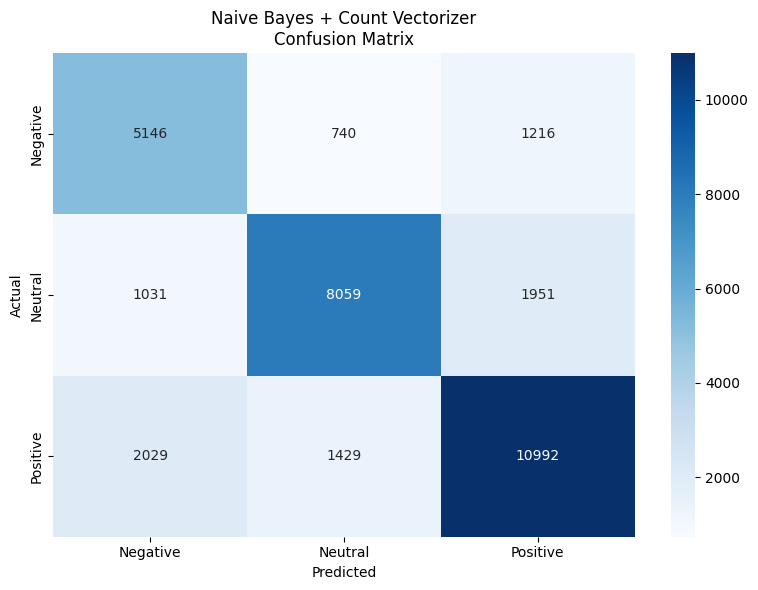

In [10]:
# Detailed evaluation for Naive Bayes + Count Vectorizer
print_classification_report(y_test, nb_count_pred, "Naive Bayes + Count Vectorizer")
plot_confusion_matrix(y_test, nb_count_pred, "Naive Bayes + Count Vectorizer\nConfusion Matrix")

### 5.2 Naive Bayes with TF-IDF

In [11]:
# Naive Bayes with TF-IDF
nb_tfidf = MultinomialNB(alpha=1.0)

nb_tfidf_model, nb_tfidf_pred, nb_tfidf_result = train_and_evaluate(
    nb_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test,
    'Naive Bayes', 'TF-IDF'
)

print("Naive Bayes + TF-IDF Results")
print("="*50)
print(f"Accuracy:  {nb_tfidf_result['Accuracy']:.4f}")
print(f"Precision: {nb_tfidf_result['Precision']:.4f}")
print(f"Recall:    {nb_tfidf_result['Recall']:.4f}")
print(f"F1-Score:  {nb_tfidf_result['F1-Score']:.4f}")

Naive Bayes + TF-IDF Results
Accuracy:  0.7195
Precision: 0.7358
Recall:    0.7195
F1-Score:  0.7122



Naive Bayes + TF-IDF
               precision    recall  f1-score   support

Negative (-1)       0.81      0.49      0.61      7102
  Neutral (0)       0.78      0.67      0.72     11041
 Positive (1)       0.67      0.87      0.76     14450

     accuracy                           0.72     32593
    macro avg       0.75      0.68      0.70     32593
 weighted avg       0.74      0.72      0.71     32593



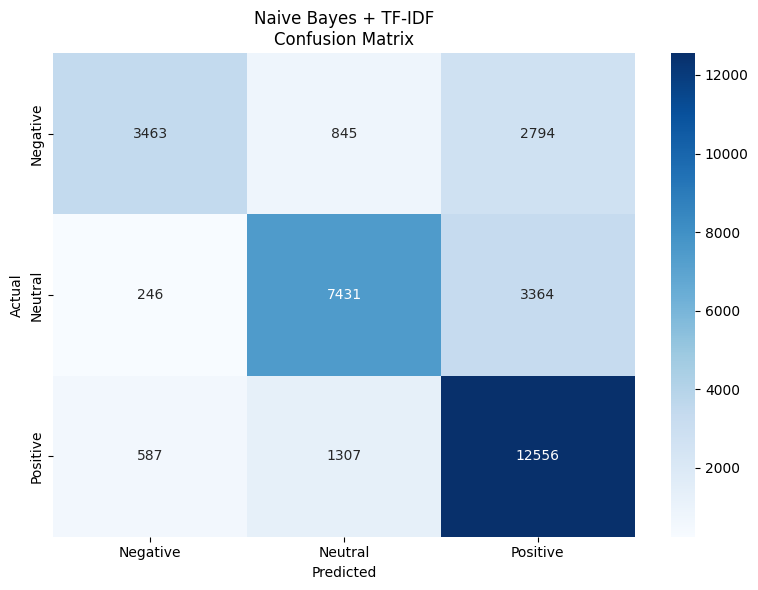

In [12]:
# Detailed evaluation for Naive Bayes + TF-IDF
print_classification_report(y_test, nb_tfidf_pred, "Naive Bayes + TF-IDF")
plot_confusion_matrix(y_test, nb_tfidf_pred, "Naive Bayes + TF-IDF\nConfusion Matrix")

### 5.3 Logistic Regression with Count Vectorizer (Word Frequency)

In [13]:
# Logistic Regression with Count Vectorizer
lr_count = LogisticRegression(
    max_iter=1000,
    C=1.0,
    class_weight='balanced',  # Handle class imbalance
    solver='lbfgs',
    random_state=42,
    n_jobs=-1
)

lr_count_model, lr_count_pred, lr_count_result = train_and_evaluate(
    lr_count, X_train_count, X_test_count, y_train, y_test,
    'Logistic Regression', 'Count Vectorizer'
)

print("Logistic Regression + Count Vectorizer Results")
print("="*50)
print(f"Accuracy:  {lr_count_result['Accuracy']:.4f}")
print(f"Precision: {lr_count_result['Precision']:.4f}")
print(f"Recall:    {lr_count_result['Recall']:.4f}")
print(f"F1-Score:  {lr_count_result['F1-Score']:.4f}")

Logistic Regression + Count Vectorizer Results
Accuracy:  0.8574
Precision: 0.8623
Recall:    0.8574
F1-Score:  0.8573



Logistic Regression + Count Vectorizer
               precision    recall  f1-score   support

Negative (-1)       0.80      0.81      0.80      7102
  Neutral (0)       0.83      0.94      0.88     11041
 Positive (1)       0.92      0.82      0.87     14450

     accuracy                           0.86     32593
    macro avg       0.85      0.86      0.85     32593
 weighted avg       0.86      0.86      0.86     32593



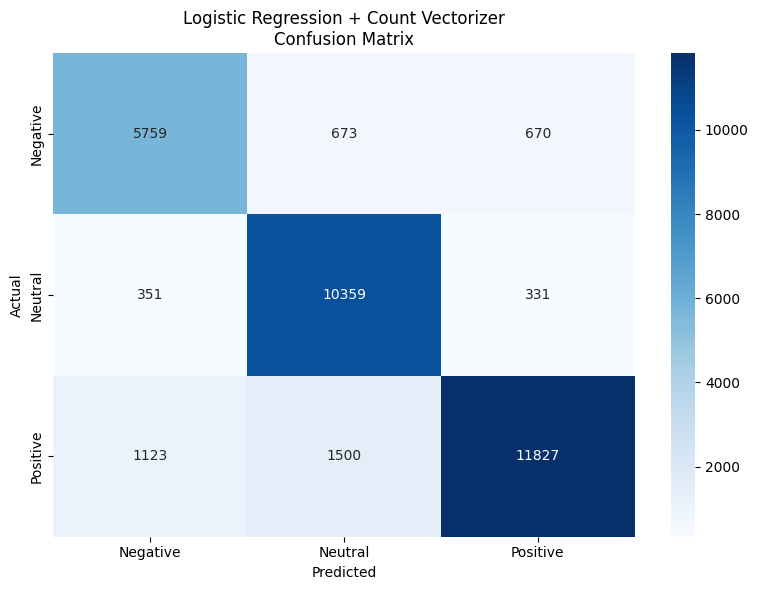

In [14]:
# Detailed evaluation for Logistic Regression + Count Vectorizer
print_classification_report(y_test, lr_count_pred, "Logistic Regression + Count Vectorizer")
plot_confusion_matrix(y_test, lr_count_pred, "Logistic Regression + Count Vectorizer\nConfusion Matrix")

### 5.4 Logistic Regression with TF-IDF

In [15]:
# Logistic Regression with TF-IDF
lr_tfidf = LogisticRegression(
    max_iter=1000,
    C=1.0,
    class_weight='balanced',
    solver='lbfgs',
    random_state=42,
    n_jobs=-1
)

lr_tfidf_model, lr_tfidf_pred, lr_tfidf_result = train_and_evaluate(
    lr_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test,
    'Logistic Regression', 'TF-IDF'
)

print("Logistic Regression + TF-IDF Results")
print("="*50)
print(f"Accuracy:  {lr_tfidf_result['Accuracy']:.4f}")
print(f"Precision: {lr_tfidf_result['Precision']:.4f}")
print(f"Recall:    {lr_tfidf_result['Recall']:.4f}")
print(f"F1-Score:  {lr_tfidf_result['F1-Score']:.4f}")

Logistic Regression + TF-IDF Results
Accuracy:  0.8553
Precision: 0.8641
Recall:    0.8553
F1-Score:  0.8550



Logistic Regression + TF-IDF
               precision    recall  f1-score   support

Negative (-1)       0.80      0.82      0.81      7102
  Neutral (0)       0.81      0.96      0.88     11041
 Positive (1)       0.94      0.80      0.86     14450

     accuracy                           0.86     32593
    macro avg       0.85      0.86      0.85     32593
 weighted avg       0.86      0.86      0.86     32593



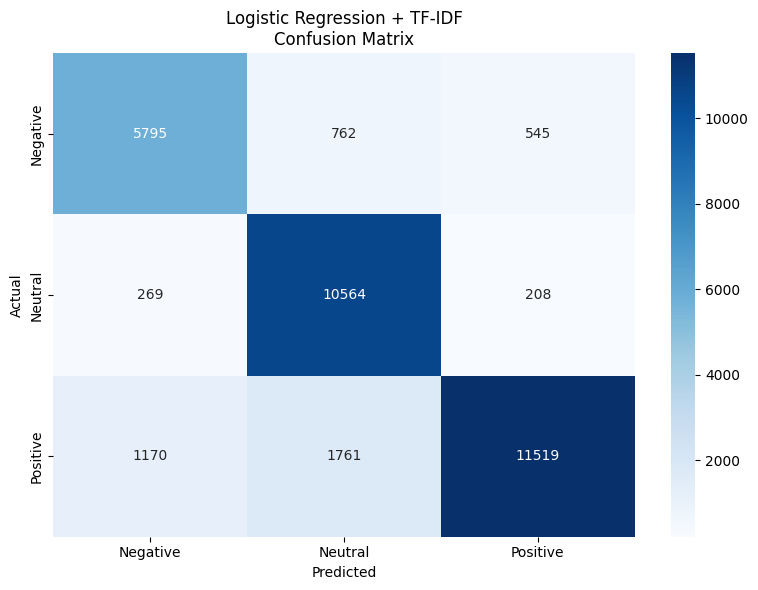

In [16]:
# Detailed evaluation for Logistic Regression + TF-IDF
print_classification_report(y_test, lr_tfidf_pred, "Logistic Regression + TF-IDF")
plot_confusion_matrix(y_test, lr_tfidf_pred, "Logistic Regression + TF-IDF\nConfusion Matrix")

## 6. Cross-Validation

Perform 5-fold cross-validation to get more robust performance estimates.

In [17]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for all model combinations
cv_results = []

print("5-Fold Cross-Validation Results")
print("="*70)

# Models and feature combinations
models_features = [
    (MultinomialNB(alpha=1.0), X_train_count, 'Naive Bayes', 'Count Vectorizer'),
    (MultinomialNB(alpha=1.0), X_train_tfidf, 'Naive Bayes', 'TF-IDF'),
    (LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, n_jobs=-1), 
     X_train_count, 'Logistic Regression', 'Count Vectorizer'),
    (LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, n_jobs=-1), 
     X_train_tfidf, 'Logistic Regression', 'TF-IDF'),
]

for model, X_features, model_name, feature_name in models_features:
    scores = cross_val_score(model, X_features, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)
    cv_results.append({
        'Model': model_name,
        'Features': feature_name,
        'CV Mean F1': scores.mean(),
        'CV Std F1': scores.std()
    })
    print(f"{model_name:20} + {feature_name:18}: F1 = {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

cv_df = pd.DataFrame(cv_results)

5-Fold Cross-Validation Results
Naive Bayes          + Count Vectorizer  : F1 = 0.7354 (+/- 0.0026)
Naive Bayes          + TF-IDF            : F1 = 0.7046 (+/- 0.0042)
Logistic Regression  + Count Vectorizer  : F1 = 0.8495 (+/- 0.0049)
Logistic Regression  + TF-IDF            : F1 = 0.8479 (+/- 0.0032)


## 7. Results Comparison

### 7.1 Summary Table

In [18]:
# Create comprehensive results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.round(4)

# Merge with CV results
results_df = results_df.merge(cv_df, on=['Model', 'Features'])

print("="*90)
print("                    BASELINE MODELS - PERFORMANCE COMPARISON")
print("="*90)
print(results_df.to_string(index=False))

# Identify best model
best_idx = results_df['F1-Score'].idxmax()
best_model = results_df.loc[best_idx]
print(f"\n🏆 Best Model: {best_model['Model']} + {best_model['Features']}")
print(f"   Test F1-Score: {best_model['F1-Score']:.4f}")
print(f"   CV F1-Score:   {best_model['CV Mean F1']:.4f} (+/- {best_model['CV Std F1']*2:.4f})")

                    BASELINE MODELS - PERFORMANCE COMPARISON
              Model         Features  Accuracy  Precision  Recall  F1-Score  CV Mean F1  CV Std F1
        Naive Bayes Count Vectorizer    0.7424     0.7477  0.7424    0.7439    0.735379   0.001290
        Naive Bayes           TF-IDF    0.7195     0.7358  0.7195    0.7122    0.704582   0.002085
Logistic Regression Count Vectorizer    0.8574     0.8623  0.8574    0.8573    0.849517   0.002462
Logistic Regression           TF-IDF    0.8553     0.8641  0.8553    0.8550    0.847931   0.001591

🏆 Best Model: Logistic Regression + Count Vectorizer
   Test F1-Score: 0.8573
   CV F1-Score:   0.8495 (+/- 0.0049)


### 7.2 Visual Comparison

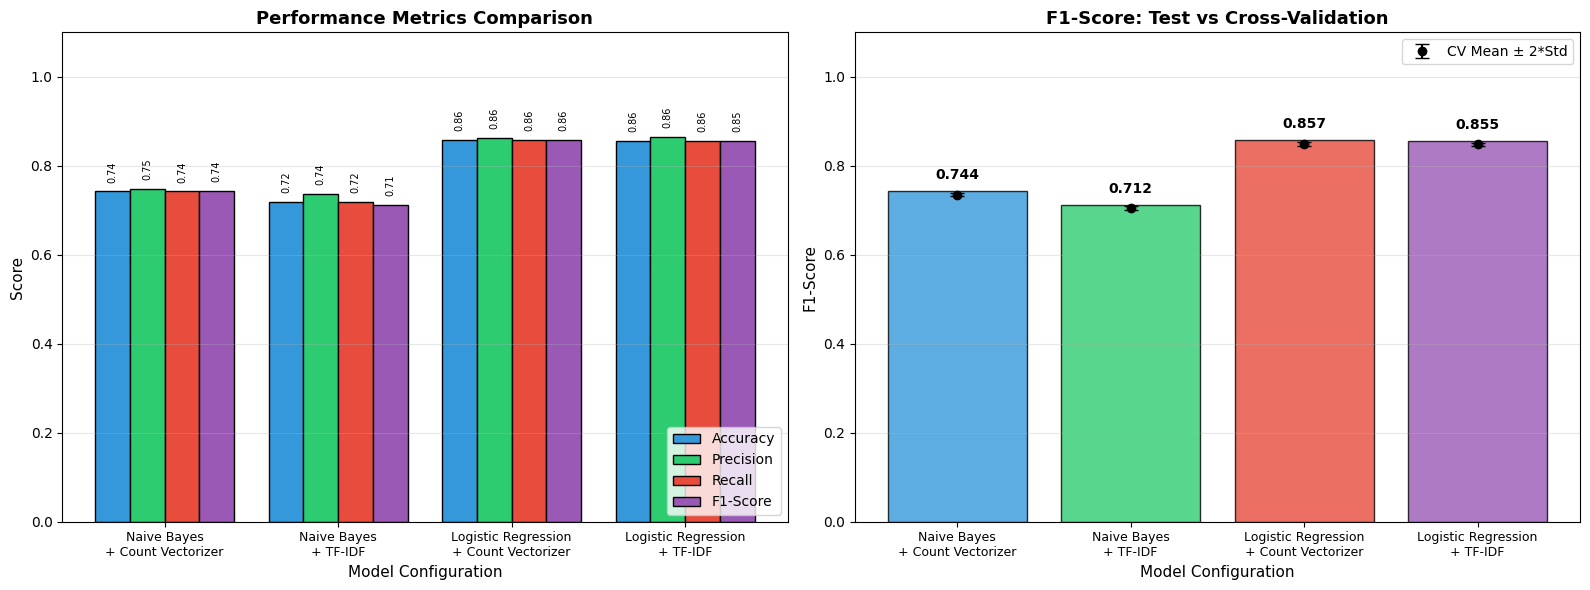

In [19]:
# Visualize results comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Create model labels
results_df['Model_Label'] = results_df['Model'] + '\n+ ' + results_df['Features']

# Plot 1: Bar chart of all metrics
x = np.arange(len(results_df))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    axes[0].bar(x + i*width, results_df[metric], width, label=metric, color=color, edgecolor='black')

axes[0].set_xlabel('Model Configuration', fontsize=11)
axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('Performance Metrics Comparison', fontsize=13, fontweight='bold')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(results_df['Model_Label'], fontsize=9)
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1.1)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, metric in enumerate(metrics):
    for j, val in enumerate(results_df[metric]):
        axes[0].text(j + i*width, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontsize=7, rotation=90)

# Plot 2: F1-Score comparison with CV error bars
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
bars = axes[1].bar(x, results_df['F1-Score'], color=colors, edgecolor='black', alpha=0.8)
axes[1].errorbar(x, results_df['CV Mean F1'], yerr=results_df['CV Std F1']*2, 
                  fmt='o', color='black', capsize=5, label='CV Mean ± 2*Std')

axes[1].set_xlabel('Model Configuration', fontsize=11)
axes[1].set_ylabel('F1-Score', fontsize=11)
axes[1].set_title('F1-Score: Test vs Cross-Validation', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model_Label'], fontsize=9)
axes[1].legend()
axes[1].set_ylim(0, 1.1)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.3f}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

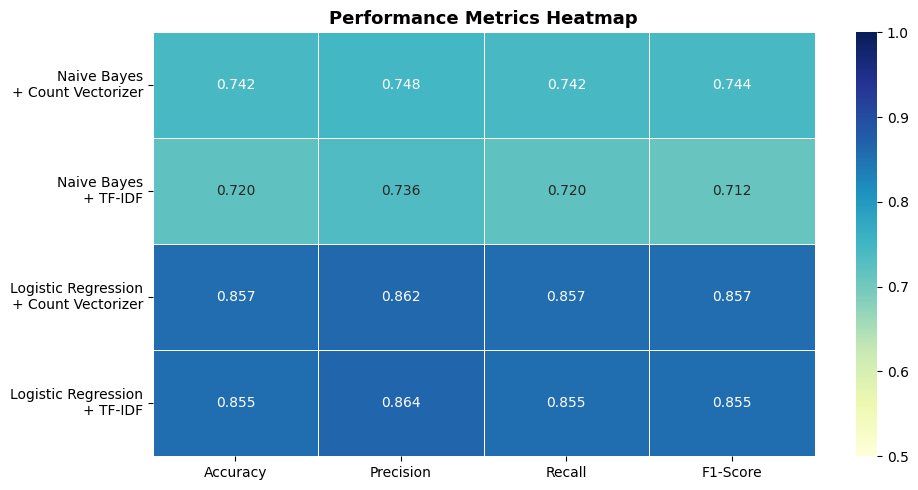

In [20]:
# Heatmap comparison
fig, ax = plt.subplots(figsize=(10, 5))

heatmap_data = results_df[['Model_Label', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].set_index('Model_Label')
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f', 
            linewidths=0.5, ax=ax, vmin=0.5, vmax=1.0)
ax.set_title('Performance Metrics Heatmap', fontsize=13, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

### 7.3 Feature Extraction Comparison

Feature Extraction Method Comparison

Average Performance by Feature Type:
                  Accuracy  Precision  Recall  F1-Score
Features                                               
Count Vectorizer    0.7999     0.8050  0.7999    0.8006
TF-IDF              0.7874     0.7999  0.7874    0.7836

Average Performance by Model Type:
                     Accuracy  Precision  Recall  F1-Score
Model                                                     
Logistic Regression    0.8564     0.8632  0.8564    0.8562
Naive Bayes            0.7310     0.7418  0.7310    0.7281


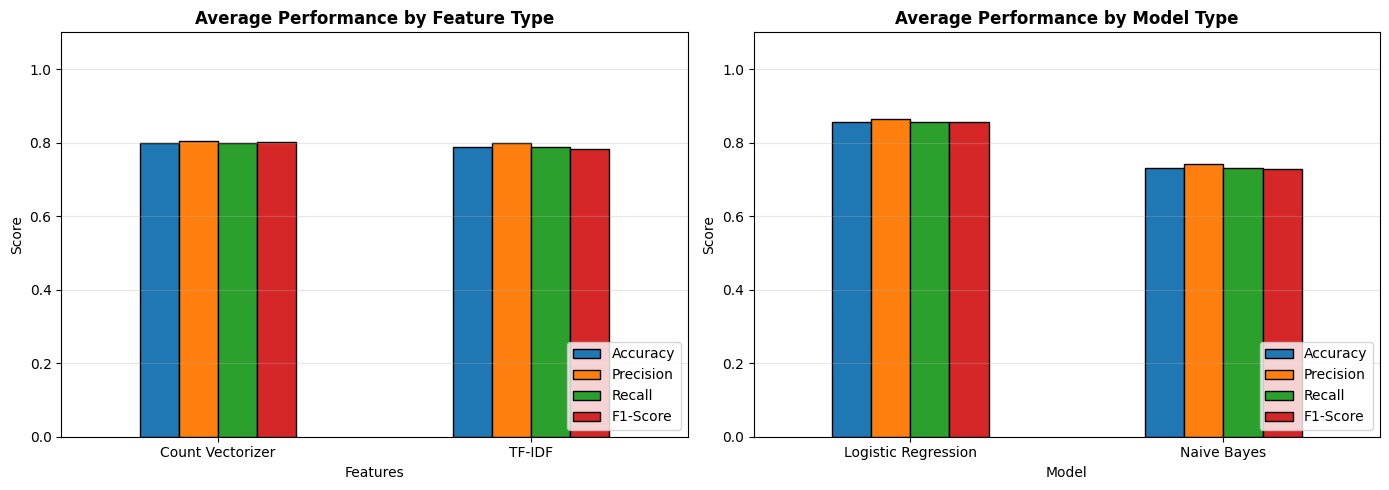

In [21]:
# Compare Count Vectorizer vs TF-IDF
print("Feature Extraction Method Comparison")
print("="*60)

# Group by feature type
feature_comparison = results_df.groupby('Features')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].mean()
print("\nAverage Performance by Feature Type:")
print(feature_comparison.round(4))

# Group by model type
model_comparison = results_df.groupby('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].mean()
print("\nAverage Performance by Model Type:")
print(model_comparison.round(4))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By Feature Type
feature_comparison.plot(kind='bar', ax=axes[0], rot=0, edgecolor='black')
axes[0].set_title('Average Performance by Feature Type', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1.1)
axes[0].grid(axis='y', alpha=0.3)

# By Model Type
model_comparison.plot(kind='bar', ax=axes[1], rot=0, edgecolor='black')
axes[1].set_title('Average Performance by Model Type', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].legend(loc='lower right')
axes[1].set_ylim(0, 1.1)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Error Analysis

Analyze misclassified samples to understand model weaknesses.

In [22]:
# Error analysis using best model predictions
# Using Logistic Regression + TF-IDF as example (typically best performer)
best_pred = lr_tfidf_pred

# Find misclassified samples
misclassified_mask = y_test != best_pred
misclassified_indices = np.where(misclassified_mask)[0]

print(f"Error Analysis (Logistic Regression + TF-IDF)")
print("="*60)
print(f"Total test samples: {len(y_test):,}")
print(f"Correctly classified: {(~misclassified_mask).sum():,}")
print(f"Misclassified: {misclassified_mask.sum():,} ({misclassified_mask.sum()/len(y_test)*100:.2f}%)")

# Analyze error distribution
print("\nMisclassification Distribution:")
for true_label in [-1, 0, 1]:
    for pred_label in [-1, 0, 1]:
        if true_label != pred_label:
            count = ((y_test == true_label) & (best_pred == pred_label)).sum()
            if count > 0:
                label_names = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
                print(f"  {label_names[true_label]} → {label_names[pred_label]}: {count:,}")

Error Analysis (Logistic Regression + TF-IDF)
Total test samples: 32,593
Correctly classified: 27,878
Misclassified: 4,715 (14.47%)

Misclassification Distribution:
  Negative → Neutral: 762
  Negative → Positive: 545
  Neutral → Negative: 269
  Neutral → Positive: 208
  Positive → Negative: 1,170
  Positive → Neutral: 1,761


In [23]:
# Show sample misclassified texts
print("\nSample Misclassified Texts:")
print("="*80)

label_names = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
sample_errors = np.random.choice(misclassified_indices, size=min(10, len(misclassified_indices)), replace=False)

for idx in sample_errors:
    true_label = y_test[idx]
    pred_label = best_pred[idx]
    text = X_test[idx][:150]
    print(f"\nText: {text}...")
    print(f"True: {label_names[true_label]} | Predicted: {label_names[pred_label]}")


Sample Misclassified Texts:

Text: not lies like narendra modi indians know that who lies more then rahul gandhi...
True: Positive | Predicted: Neutral

Text: who these called top economists nidhi barkha shekhar rajan etcsame economists had abused modi after announced rupees per year for smallmarginal farmer...
True: Neutral | Predicted: Negative

Text: but don know why sympathies dreadful terrorist burman vani supposedly doing serve her anti modi agenda somehow trying garner support for sum scion the...
True: Negative | Predicted: Neutral

Text: the other side the border they have started the terrorist head count...
True: Negative | Predicted: Neutral

Text: truemaybe after few years modis clout goes yogi fadnavis takes overthe same set people their descendants will find divinity serenity himacc meadvani w...
True: Positive | Predicted: Neutral

Text: dear narendra modi dont want surgical any more frnkly more development wrks fix this traitor first had enough enough...
True: Positive

## 9. Save Models and Results

In [24]:
import joblib
import os

# Create models directory
os.makedirs('../models', exist_ok=True)

# Save best models and vectorizers
joblib.dump(lr_tfidf_model, '../models/logistic_regression_tfidf.joblib')
joblib.dump(tfidf_vectorizer, '../models/tfidf_vectorizer.joblib')
joblib.dump(lr_count_model, '../models/logistic_regression_count.joblib')
joblib.dump(count_vectorizer, '../models/count_vectorizer.joblib')
joblib.dump(nb_tfidf_model, '../models/naive_bayes_tfidf.joblib')
joblib.dump(nb_count_model, '../models/naive_bayes_count.joblib')

print("✓ Models saved to ../models/")

# Save results to CSV
results_df.to_csv('../reports/baseline_model_results.csv', index=False)
print("✓ Results saved to ../reports/baseline_model_results.csv")

print("\nSaved files:")
print("  - logistic_regression_tfidf.joblib")
print("  - logistic_regression_count.joblib")
print("  - naive_bayes_tfidf.joblib")
print("  - naive_bayes_count.joblib")
print("  - tfidf_vectorizer.joblib")
print("  - count_vectorizer.joblib")

✓ Models saved to ../models/
✓ Results saved to ../reports/baseline_model_results.csv

Saved files:
  - logistic_regression_tfidf.joblib
  - logistic_regression_count.joblib
  - naive_bayes_tfidf.joblib
  - naive_bayes_count.joblib
  - tfidf_vectorizer.joblib
  - count_vectorizer.joblib


## 10. Summary & Conclusions

In [25]:
# Final Summary
print("="*80)
print("                    BASELINE MODELS - FINAL SUMMARY")
print("="*80)

print("\n📊 EXPERIMENT CONFIGURATION")
print("-"*40)
print(f"  Dataset Size: {len(X):,} samples")
print(f"  Train/Test Split: 80/20")
print(f"  Cross-Validation: 5-fold Stratified")
print(f"  Feature Extraction: Count Vectorizer, TF-IDF")
print(f"  Max Features: 10,000")
print(f"  N-gram Range: (1, 2)")

print("\n📈 RESULTS SUMMARY")
print("-"*40)
for _, row in results_df.iterrows():
    print(f"\n  {row['Model']} + {row['Features']}:")
    print(f"    Accuracy:  {row['Accuracy']:.4f}")
    print(f"    F1-Score:  {row['F1-Score']:.4f}")
    print(f"    CV F1:     {row['CV Mean F1']:.4f} (±{row['CV Std F1']*2:.4f})")

print("\n🏆 BEST PERFORMING MODEL")
print("-"*40)
best_row = results_df.loc[results_df['F1-Score'].idxmax()]
print(f"  Model: {best_row['Model']} + {best_row['Features']}")
print(f"  Accuracy:  {best_row['Accuracy']:.4f}")
print(f"  Precision: {best_row['Precision']:.4f}")
print(f"  Recall:    {best_row['Recall']:.4f}")
print(f"  F1-Score:  {best_row['F1-Score']:.4f}")

print("\n💡 KEY FINDINGS")
print("-"*40)
# Compare TF-IDF vs Count
tfidf_avg = results_df[results_df['Features']=='TF-IDF']['F1-Score'].mean()
count_avg = results_df[results_df['Features']=='Count Vectorizer']['F1-Score'].mean()
print(f"  • TF-IDF avg F1: {tfidf_avg:.4f} vs Count Vectorizer avg F1: {count_avg:.4f}")
if tfidf_avg > count_avg:
    print(f"    → TF-IDF performs better by {(tfidf_avg-count_avg)*100:.2f}%")
else:
    print(f"    → Count Vectorizer performs better by {(count_avg-tfidf_avg)*100:.2f}%")

# Compare models
nb_avg = results_df[results_df['Model']=='Naive Bayes']['F1-Score'].mean()
lr_avg = results_df[results_df['Model']=='Logistic Regression']['F1-Score'].mean()
print(f"  • Naive Bayes avg F1: {nb_avg:.4f} vs Logistic Regression avg F1: {lr_avg:.4f}")
if lr_avg > nb_avg:
    print(f"    → Logistic Regression performs better by {(lr_avg-nb_avg)*100:.2f}%")
else:
    print(f"    → Naive Bayes performs better by {(nb_avg-lr_avg)*100:.2f}%")

print("\n📝 NEXT STEPS")
print("-"*40)
print("  1. Experiment with word embeddings (Word2Vec, GloVe, FastText)")
print("  2. Try deep learning models (LSTM, CNN)")
print("  3. Fine-tune transformer models (BERT, RoBERTa)")
print("  4. Hyperparameter tuning for best baseline model")
print("  5. Ensemble methods combining multiple models")

print("\n" + "="*80)
print("                         BASELINE EVALUATION COMPLETE")
print("="*80)

                    BASELINE MODELS - FINAL SUMMARY

📊 EXPERIMENT CONFIGURATION
----------------------------------------
  Dataset Size: 162,962 samples
  Train/Test Split: 80/20
  Cross-Validation: 5-fold Stratified
  Feature Extraction: Count Vectorizer, TF-IDF
  Max Features: 10,000
  N-gram Range: (1, 2)

📈 RESULTS SUMMARY
----------------------------------------

  Naive Bayes + Count Vectorizer:
    Accuracy:  0.7424
    F1-Score:  0.7439
    CV F1:     0.7354 (±0.0026)

  Naive Bayes + TF-IDF:
    Accuracy:  0.7195
    F1-Score:  0.7122
    CV F1:     0.7046 (±0.0042)

  Logistic Regression + Count Vectorizer:
    Accuracy:  0.8574
    F1-Score:  0.8573
    CV F1:     0.8495 (±0.0049)

  Logistic Regression + TF-IDF:
    Accuracy:  0.8553
    F1-Score:  0.8550
    CV F1:     0.8479 (±0.0032)

🏆 BEST PERFORMING MODEL
----------------------------------------
  Model: Logistic Regression + Count Vectorizer
  Accuracy:  0.8574
  Precision: 0.8623
  Recall:    0.8574
  F1-Score:  0.8